In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation
from keras.optimizers import RMSprop, adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

# For adding new activation function
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from tensorflow.python.client import device_lib
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#session = tf.Session(config=config)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

sns.set(style='white', context='notebook', palette='deep')

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
K.tensorflow_backend._get_available_gpus() #To check if GPU is detected
from pandas import DataFrame as df

Load Data

In [3]:
# Load the data
train1 = pd.read_csv("train.csv")
train2 = pd.read_csv("A_Z Handwritten Data.csv")

In [4]:
print(np.shape(train1))#Total number of alphabets present
print(np.shape(train2))#Total number of digits present

(42000, 785)
(372450, 785)


In [5]:
train1 = df.as_matrix(train1)
train2 = df.as_matrix(train2)
train2[:,0] += 10

In [6]:
print(np.shape(train1))
print(np.shape(train2))
train = np.concatenate((train1,train2),axis=0)
del train1, train2

(42000, 785)
(372450, 785)


In [7]:
print(np.shape(train))

(414450, 785)


In [8]:
Y_train = train[:,0]
X_train = train[:,1::]
del train
print(np.shape(X_train))
print(np.shape(Y_train))

(414450, 784)
(414450,)


In [9]:
#Y_train = pd.DataFrame(Y_train)
X_train = pd.DataFrame(X_train)

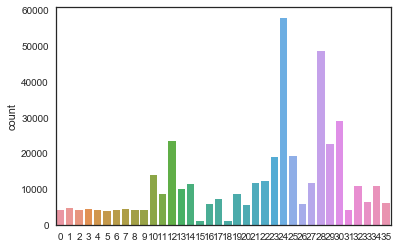

In [10]:
# free some space
#del train 

g = sns.countplot(Y_train)

In [11]:
# Normalize the data
X_train = X_train / 255

In [12]:
# Reshape image in 3 dimensions (height = 28, width = 28 , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)

In [13]:
# Encode labels to one hot vectors
Y_train = to_categorical(Y_train, num_classes = 36)

In [14]:
# Set the random seed
random_seed = 2

# Split the train and the validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

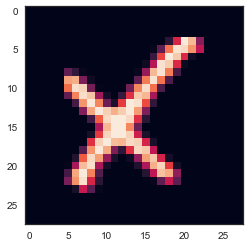

In [15]:
g = plt.imshow(X_train[5][:,:,0])

In [16]:
def swish(x):
    return (K.sigmoid(x) * x)

get_custom_objects().update({'swish': swish})

In [17]:
# Set the CNN model 

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='swish', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='swish'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='swish'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='swish'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "swish"))
model.add(Dropout(0.5))
model.add(Dense(36, activation = "softmax"))

In [18]:
# Define the optimizer
optimizer = adam(lr=0.001,  epsilon=1e-08, decay=0.0)
#optimizer=adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

# Compile the model
#model.compile(optimizer = optimizer , loss = "mean_squared_error", metrics=["accuracy"])
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [19]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [20]:
epochs = 4
batch_size = 86

In [21]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)
#print(np.shape(X_train))

In [22]:
# Fit the model
#with tf.device('/cpu:0'):
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction]
                             )

Epoch 1/4
4337/4337 [==============================] - 679s 156ms/step - loss: 0.3412 - acc: 0.9038 - val_loss: 0.1148 - val_acc: 0.9671
Epoch 2/4
4337/4337 [==============================] - 650s 150ms/step - loss: 0.1890 - acc: 0.9461 - val_loss: 0.1085 - val_acc: 0.9693
Epoch 3/4
4337/4337 [==============================] - 646s 149ms/step - loss: 0.1739 - acc: 0.9512 - val_loss: 0.1061 - val_acc: 0.9699
Epoch 4/4
4337/4337 [==============================] - 643s 148ms/step - loss: 0.1688 - acc: 0.9523 - val_loss: 0.1001 - val_acc: 0.9723


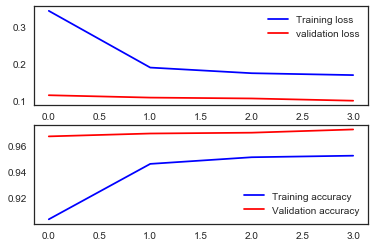

In [23]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

total error: (1146,)


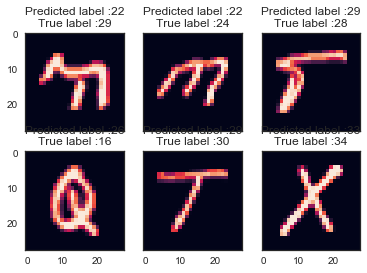

In [35]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (y_pred - y_true != 0)

Y_pred_classes_errors = y_pred[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 10
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-16:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

print('total error:',sorted_dela_errors.shape)

In [28]:
model.save('my_model_az.h5')